In [ ]:
import sys

sys.path.append('../')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates.all import *

from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models.all import *
from mrl.vocab import *
from mrl.policy_gradient import *
from mrl.train.all import *

In [4]:
os.environ['ncpus'] = '0'
torch.cuda.set_device(0)
set_global_pool(cpus=10)

In [5]:
torch.cuda.empty_cache()

## Reward Function

In [5]:
df = pd.read_csv('../nbs/untracked_files/affinity_data.csv')
df = df[df.smiles.map(lambda x: not '.' in x)]

In [6]:
reward_model = MLP_Encoder(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2])
r_ds = Vec_Prediction_Dataset(df.smiles.values, df.value.values/10, ECFP6)
r_agent = PredictiveAgent(reward_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

In [7]:
r_agent.train_supervised(32, 12, 1e-3, percent_valid=0.1)

Epoch,Train Loss,Valid Loss,Time
0,0.17009,0.15867,00:08
1,0.13449,0.13572,00:07
2,0.04716,0.04434,00:07
3,0.09222,0.05951,00:07
4,0.06012,0.03653,00:07
5,0.04333,0.02593,00:07
6,0.05999,0.02924,00:07
7,0.02261,0.02106,00:07
8,0.02450,0.02146,00:07
9,0.03441,0.03295,00:07


In [8]:
r_agent.save_weights('../nbs/untracked_files/affinity_mlp.pt')

In [9]:
r_agent.load_weights('../nbs/untracked_files/affinity_mlp.pt')

In [10]:
# validate

_, valid_ds = r_ds.split(0.1)

valid_dl = valid_ds.dataloader(256, num_workers=0, shuffle=False)
r_agent.model.eval();

preds = []
targs = []

with torch.no_grad():
    for i, batch in enumerate(valid_dl):
        batch = to_device(batch)
        x,y = batch
        pred = r_agent.model(x)
        preds.append(pred.detach().cpu())
        targs.append(y.detach().cpu())
        
preds = torch.cat(preds).numpy()
targs = torch.cat(targs).numpy()

Text(0.9, 0.2, 'R-squared = 0.69')

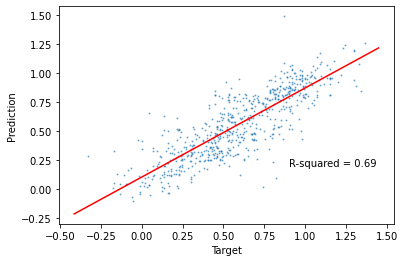

In [22]:
fig, ax = plt.subplots()

ax.scatter(targs, preds, alpha=0.5, s=1)
plt.xlabel('Target')
plt.ylabel('Prediction')

slope, intercept = np.polyfit(targs, preds, 1)
ax.plot(np.array(ax.get_xlim()), intercept + slope*np.array(ax.get_xlim()), c='r')

preds = preds.squeeze(-1)

ybar = targs.mean()
ssreg = ((preds-targs)**2).sum()
sstot = ((targs-ybar)**2).sum()
r_sq = 1-ssreg/sstot

plt.text(0.9, 0.2, 'R-squared = %0.2f' % r_sq)

## Generative RL

In [6]:
# def scale_sa(sa):
#     return (10-sa)/9

# template = Template([ValidityFilter(), 
#                      SingleCompoundFilter(), 
#                      RotBondFilter(None, 8),
#                      ChargeFilter(None, 0)],
#                     [QEDFilter(0.5, None, score=1.),
#                      SAFilter(None, 6, score=1.)], 
#                     fail_score=-10., log=False)

smarts = ['[#6](=[#16])(-[#7])-[#7]',
        '[H]-[#6](-[H])=[#6]-[*]',
        '[#6]=[#6]=[#6]',
        '[#7][F,Cl,Br,I]',
        '[#6;!R]=[#6;!R]-[#6;!R]=[#6;!R]']

template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 8),
                     HeteroatomFilter(None, 8),
                     ChargeFilter(None, 0),
                     MaxRingFilter(None, 6),
                     MinRingFilter(5, None),
                     HBDFilter(None, 5),
                     HBAFilter(None, 10),
                     MolWtFilter(None, 500),
                     LogPFilter(None, 5),
                     SAFilter(None, 7),
                     BridgeheadFilter(None,0),
                     PAINSAFilter(),
                     ExclusionFilter(smarts, criteria='any'),
                     RotChainFilter(None, 7)
                    ],
                    [], 
                    fail_score=-10., log=False, use_lookup=True)

template_cb = TemplateCallback(template, prefilter=True)

In [7]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)

loss = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})

In [8]:
r_model = MLP_Encoder(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2])

r_ds = Vec_Prediction_Dataset(['C'], [0], partial(failsafe_fp, fp_function=ECFP6))

r_agent = PredictiveAgent(r_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

r_agent.load_weights('../nbs/untracked_files/affinity_mlp.pt')

r_model.eval();

freeze(r_model)

reward = Reward(r_agent.predict_data, weight=-10.)

aff_reward = RewardCallback(reward, 'aff')


# aff_reward = FunctionReward(r_agent.predict_data, 
#                             'aff', 
#                             weight=-10.)

In [9]:
aff_reward.reward(['CCC'])

tensor(-9.0583, device='cuda:0')

In [10]:
temp_df = pd.read_csv('template_filtered.csv')
temp_df.shape

(4206402, 1)

### FP VAE

In [10]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB, prefunc=remove_stereo)

ds = Vec_To_Text_Dataset(['C'], vocab, ECFP6)
supervised_loss = VAELoss(weight=0.5)

d_vocab = len(vocab.itos)
d_embedding = 256
encoder_d_in = 2048
encoder_dims = [1024, 512]
encoder_drops = [0.1, 0.1]
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bidir = False
condition_hidden = True
condition_output = True
bos_idx = vocab.stoi['bos']


model = MLP_VAE(
            d_vocab,
            d_embedding,
            encoder_d_in,
            encoder_dims,
            encoder_drops,
            d_hidden,
            n_layers,
            d_latent,
            input_dropout=input_dropout,
            lstm_dropout=lstm_dropout,
            condition_hidden=condition_hidden,
            condition_output=condition_output,
            prior=None,
            bos_idx=bos_idx,
            transition=None,
        )

model.z_scale = 0.1

model.load_state_dict(torch.load('../nbs/untracked_files/fp_vae_zinc.pt'))

<All keys matched successfully>

In [11]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-6},
                       base_update_iter=5, base_update=.97)

In [12]:
os.environ['ncpus'] = '24'
agent.update_dataset_from_inputs(temp_df.smiles.values[:1000000])
agent.train_supervised(1000, 1, 5e-5)
agent.base_model.load_state_dict(agent.model.state_dict())
os.environ['ncpus'] = '0'
refresh_global_pool()

Epoch,Train Loss,Valid Loss,Time
0,0.36295,0.35611,04:06


In [13]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0., gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('samples', 'rewards', 10, 95, 100, vocab, 0.1)

samplers = [sampler1, sampler2, sampler3, sampler4]

In [14]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
retrain_cb = ResetAndRetrain(agent, 2000, '../nbs/untracked_files/fp_vae_zinc.pt',
               90, 5e-5, 64, 3)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)
new_cb = NoveltyReward(weight=0.05)

cbs = [new_cb, supervised_cb, live_p90, live_max, retrain_cb]

In [15]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], loss_cbs=[loss],
                 cbs=cbs)

In [20]:
env.fit(200, 90, 4000, 20)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,aff,novel,PPO,rewards_live_p90,rewards_live_max
0,-8.534,-8.534,1.000,1.000,200,0.000,1.000,-8.534,0.050,0.277,-7.182,-5.577
20,-8.156,-8.156,0.940,1.000,200,0.000,1.000,-8.156,0.047,0.360,-7.122,-5.677
40,-8.299,-8.299,0.950,1.000,200,0.000,1.000,-8.299,0.047,0.309,-6.893,-4.686
60,-8.102,-8.102,0.935,1.000,200,0.000,1.000,-8.102,0.047,0.354,-7.013,-5.076
80,-8.260,-8.260,0.955,1.000,200,0.000,1.000,-8.260,0.048,0.335,-7.074,-4.411
100,-8.141,-8.141,0.975,1.000,200,0.000,1.000,-8.141,0.049,0.409,-6.705,-4.128
120,-8.114,-8.114,0.910,1.000,200,0.000,1.000,-8.114,0.045,0.358,-6.738,-4.779
140,-8.129,-8.129,0.925,1.000,200,0.000,1.000,-8.129,0.046,0.369,-6.829,-4.784
160,-8.237,-8.237,0.945,1.000,200,0.000,1.000,-8.237,0.047,0.320,-7.251,-5.480
180,-8.209,-8.209,0.950,1.000,200,0.000,1.000,-8.209,0.047,0.323,-6.671,-3.828


Epoch,Train Loss,Valid Loss,Time
0,0.45661,0.38860,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.40142,0.38082,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.37090,0.34228,00:05


Epoch,Train Loss,Valid Loss,Time
0,0.43816,0.45864,00:07


Epoch,Train Loss,Valid Loss,Time
0,0.83668,5.95736,00:08


Epoch,Train Loss,Valid Loss,Time
0,2.37304,1.98952,00:09


Epoch,Train Loss,Valid Loss,Time
0,1.12589,1.63452,00:10


Epoch,Train Loss,Valid Loss,Time
0,0.55425,0.51354,00:11


Epoch,Train Loss,Valid Loss,Time
0,0.40411,0.39455,00:12


Epoch,Train Loss,Valid Loss,Time
0,0.26311,0.28806,00:13


Epoch,Train Loss,Valid Loss,Time
0,0.29201,0.24972,00:44
1,0.24811,0.22768,00:45
2,0.26361,0.22566,00:45


Epoch,Train Loss,Valid Loss,Time
0,0.23687,0.20234,00:14


Epoch,Train Loss,Valid Loss,Time
0,0.22073,0.19128,00:15


Epoch,Train Loss,Valid Loss,Time
0,0.21887,0.21131,00:16


Epoch,Train Loss,Valid Loss,Time
0,0.22824,0.21284,00:17


Epoch,Train Loss,Valid Loss,Time
0,0.18125,0.20711,00:17


Epoch,Train Loss,Valid Loss,Time
0,0.20313,0.21731,00:18


Epoch,Train Loss,Valid Loss,Time
0,0.19415,0.19454,00:19


Epoch,Train Loss,Valid Loss,Time
0,0.19952,0.22883,00:19


Epoch,Train Loss,Valid Loss,Time
0,0.20276,0.22772,00:20


Epoch,Train Loss,Valid Loss,Time
0,0.20330,0.19494,00:21


Epoch,Train Loss,Valid Loss,Time
0,0.27225,0.24658,01:09
1,0.23391,0.22629,01:09
2,0.21997,0.22496,01:10


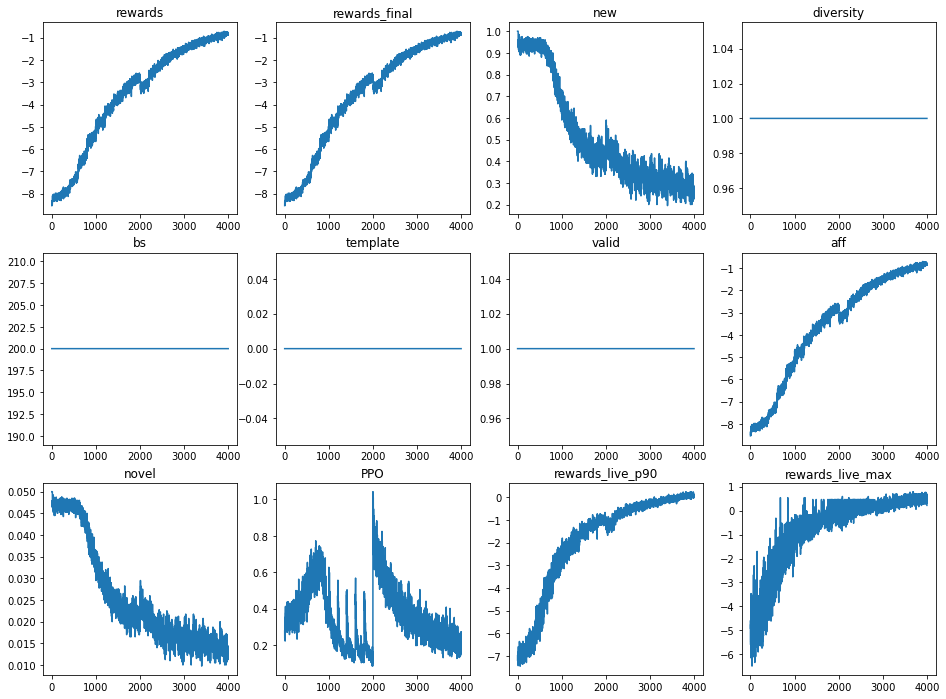

In [21]:
env.log.plot_metrics()

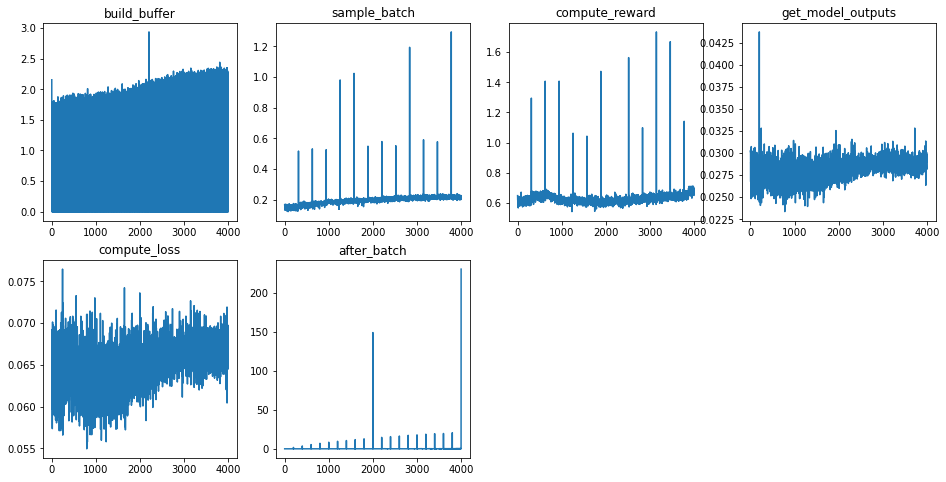

In [22]:
env.log.plot_timelog()

In [26]:
env.log.df[env.log.df.aff>0.7]

,samples,sources,rewards,rewards_final,template,aff,novel,PPO
365186,CC1CCC(C(=O)NC2(CNCC3CCC4(CCCCC4O)CO3)CCCOC2)C1,live_buffer,0.756291,0.706291,0.0,0.706291,0.05,-0.739337
376769,CC1CCC(CN2CCC(CN(C)C(=O)c3ccc4c(O)ncnc4c3)C2)C1,base_buffer,0.786368,0.736368,0.0,0.736368,0.05,1.454214
379844,CC1CCC(C(=O)NC2(CNCC3CCC4(CCCCC4O)CC3O)CCCOC2)C1,base_buffer,0.816709,0.766709,0.0,0.766709,0.05,-0.921426
384886,CC1CCC(C(=O)NC2(CNCC3CC4(CCCCC4O)CCC3O)CCCOC2)C1,base_buffer,0.777348,0.727348,0.0,0.727348,0.05,-1.013654
387696,CC1CCC(C(=O)NC2(CNCC3CCC4(CCCCC4O)CC3N)CCCOC2)C1,base_buffer,0.802162,0.752162,0.0,0.752162,0.05,-1.135433
388433,CC1CCC(C(=O)NC2(CNC(=O)C3(F)CCCOC3)CC3CCCCC3O2)C1,live_buffer,0.813955,0.763955,0.0,0.763955,0.05,-0.763981
392945,CC1CCC(C(=O)NCC2CCC(CN(C)C(=O)c3cccc(O)c3)C2)C1,live_buffer,0.845509,0.795509,0.0,0.795509,0.05,0.010238
393922,CC1CCC(C(=O)NC2(CNCC3CC4(CCCOC4)OC3C)CCCOC2)C1,live_buffer,0.765469,0.715469,0.0,0.715469,0.05,-0.870141
394087,CC1CCC(Cn2c(-c3ccc(O)cc3)nnc2N2CC(O)CCC2(C)C2C...,live_buffer,0.755247,0.705247,0.0,0.705247,0.05,-0.925268
402898,CC1CCC(C(=O)NC2(CNCC3CC4(CCCCC4C)CO3)CCCOC2)C1,base_buffer,0.779431,0.729431,0.0,0.729431,0.05,-1.089720


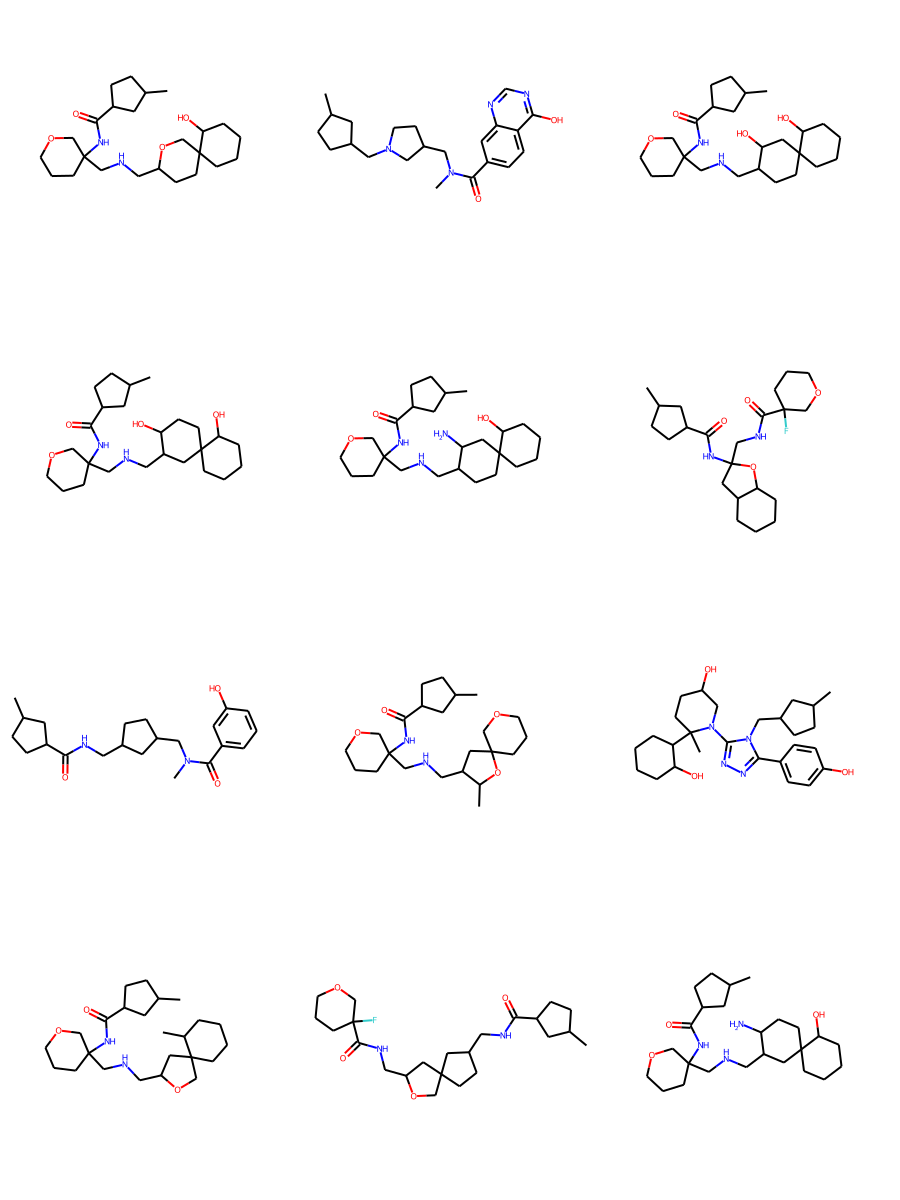

In [27]:
draw_mols(to_mols(env.log.df[env.log.df.aff>0.7].samples.values))

## Modern LSTM

In [10]:
from mrl.model_zoo import *

In [11]:
agent = LSTM_LM_Small_ZINC_NC(drop_scale=0.3, opt_kwargs={'lr':5e-5})

In [13]:
os.environ['ncpus'] = '16'
agent.update_dataset_from_inputs(temp_df.smiles.values[:1000000])
agent.train_supervised(800, 1, 5e-5)
agent.base_model.load_state_dict(agent.model.state_dict())
os.environ['ncpus'] = '0'
refresh_global_pool()

Epoch,Train Loss,Valid Loss,Time
0,0.33525,0.33073,03:48


In [12]:
gc.collect()
torch.cuda.empty_cache()

In [12]:
gen_bs = 1500

sampler1 = ModelSampler(agent.vocab, agent.model, 'live', 1000, 0.4, gen_bs)
sampler2 = ModelSampler(agent.vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)

samplers = [sampler1, sampler2, sampler3]

In [13]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)
retrain_cb = ResetAndRetrain(agent, 2000, '../nbs/untracked_files/lstm_lm_zinc_nc.pt',
               90, 5e-5, 64, 3)
new_cb = NoveltyReward(weight=0.05)
tm_cb = MurckoTimeout(20)

cbs = [new_cb, supervised_cb, live_p90, live_max, retrain_cb, tm_cb]

In [14]:
env = Environment(agent, template_cb, samplers=samplers, rewards=[aff_reward], losses=[loss],
                 cbs=cbs)

In [18]:
env.fit(200, 90, 4000, 20)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,novel,murcko_timeout,PPO,rewards_live_p90,rewards_live_max
0,-8.308,-8.308,1.000,1.000,176,0.000,0.895,1.000,0.725,-8.323,1.000,-8.308,0.050,0.983,0.329,-6.911,-4.750
20,-8.359,-8.359,1.000,1.000,152,0.000,0.885,1.000,0.600,-8.398,1.000,-8.359,0.050,0.859,0.292,-6.922,-4.661
40,-8.357,-8.357,0.973,1.000,147,0.000,0.865,1.000,0.550,-8.556,1.000,-8.357,0.049,0.850,0.268,-7.165,-6.027
60,-8.109,-8.109,0.957,1.000,139,0.000,0.835,1.000,0.500,-8.169,1.000,-8.109,0.048,0.832,0.379,-6.633,-5.284
80,-8.466,-8.466,0.979,1.000,146,0.000,0.865,1.000,0.562,-8.557,1.000,-8.466,0.049,0.844,0.291,-7.215,-5.701
100,-8.104,-8.104,0.942,1.000,139,0.000,0.870,1.000,0.562,-8.243,1.000,-8.104,0.047,0.799,0.496,-6.924,-4.078
120,-8.146,-8.146,0.954,1.000,153,0.000,0.890,1.000,0.637,-8.081,1.000,-8.146,0.048,0.860,0.407,-6.565,-3.599
140,-8.092,-8.092,0.935,1.000,153,0.000,0.870,1.000,0.600,-7.994,1.000,-8.092,0.047,0.879,0.480,-6.741,-4.678
160,-8.066,-8.066,0.961,1.000,152,0.000,0.850,1.000,0.562,-7.919,1.000,-8.066,0.048,0.894,0.372,-6.502,-4.849
180,-8.212,-8.212,0.980,1.000,151,0.000,0.870,1.000,0.588,-8.150,1.000,-8.212,0.049,0.868,0.361,-6.792,-4.646


Epoch,Train Loss,Valid Loss,Time
0,0.35318,0.38198,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.37564,0.33355,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.35012,0.60293,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.33095,0.37523,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.33434,0.34877,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.32027,0.29782,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.31683,0.27666,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.29767,0.28416,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.26266,0.25922,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.26687,0.23409,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.28474,0.30249,00:10
1,0.25126,0.29188,00:10
2,0.32683,0.29111,00:10


Epoch,Train Loss,Valid Loss,Time
0,0.25863,0.24466,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.23915,0.23795,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.23148,0.23933,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.23452,0.21400,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.20916,0.22406,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.21289,0.22461,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.22677,0.21668,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.23696,0.23554,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.20813,0.22182,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.21722,0.21713,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.23667,0.31027,00:12
1,0.22359,0.30417,00:12
2,0.22980,0.29994,00:12


### LSTM LM

In [10]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB, prefunc=remove_stereo)

ds = Text_Dataset(['C'], vocab)
supervised_loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc_nc.pt'))

<All keys matched successfully>

In [11]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-6},
                       base_update_iter=5, base_update=.97)

In [12]:
os.environ['ncpus'] = '16'
agent.update_dataset_from_inputs(temp_df.smiles.values[:1000000])
agent.train_supervised(1200, 1, 5e-5)
agent.base_model.load_state_dict(agent.model.state_dict())
os.environ['ncpus'] = '0'
refresh_global_pool()

Epoch,Train Loss,Valid Loss,Time
0,0.33851,0.33184,03:23


In [13]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.4, gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('samples', 'rewards', 10, 95, 100, vocab, 0.1)

samplers = [sampler1, sampler2, sampler3, sampler4]

In [14]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)
retrain_cb = ResetAndRetrain(agent, 2000, '../nbs/untracked_files/lstm_lm_zinc_nc.pt',
               90, 5e-5, 64, 3)
new_cb = NoveltyReward(weight=0.05)
tm_cb = MurckoTimeout(20)

cbs = [new_cb, supervised_cb, live_p90, live_max, retrain_cb, tm_cb]

In [15]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], loss_cbs=[loss],
                 cbs=cbs)

In [19]:
env.fit(200, 90, 4000, 20)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,novel,PPO,rewards_live_p90,rewards_live_max
0,-8.560,-8.560,1.000,1.000,179,0.000,0.895,1.000,0.738,-8.616,1.000,-8.560,0.050,0.243,-7.661,-4.535
20,-8.151,-8.151,0.950,1.000,181,0.000,0.905,1.000,0.762,-8.147,1.000,-8.151,0.048,0.407,-6.761,-4.152
40,-8.372,-8.372,0.967,1.000,180,0.000,0.900,1.000,0.750,-8.511,1.000,-8.372,0.048,0.316,-7.457,-4.040
60,-8.406,-8.406,0.947,1.000,169,0.000,0.845,1.000,0.613,-8.378,1.000,-8.406,0.047,0.293,-7.393,-4.692
80,-8.165,-8.165,0.972,1.000,178,0.000,0.890,1.000,0.725,-8.287,1.000,-8.165,0.049,0.375,-6.365,-3.871
100,-8.395,-8.395,0.978,1.000,180,0.000,0.900,1.000,0.750,-8.628,1.000,-8.395,0.049,0.277,-7.266,-5.390
120,-8.274,-8.274,0.972,1.000,179,0.000,0.895,1.000,0.738,-8.370,1.000,-8.274,0.049,0.311,-7.039,-4.176
140,-8.359,-8.359,0.955,1.000,179,0.000,0.895,1.000,0.738,-8.459,1.000,-8.359,0.048,0.290,-7.128,-4.983
160,-8.199,-8.199,0.948,1.000,174,0.000,0.870,1.000,0.675,-8.580,1.000,-8.199,0.047,0.282,-7.121,-4.576
180,-8.196,-8.196,0.967,1.000,182,0.000,0.910,1.000,0.775,-8.216,1.000,-8.196,0.048,0.294,-6.889,-4.692


Epoch,Train Loss,Valid Loss,Time
0,0.36501,0.36267,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.36228,0.34782,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.35103,0.36626,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.36146,0.37628,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.39210,0.33821,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.28062,0.31745,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.29652,0.27140,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.22437,0.26459,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.23603,0.26300,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.21030,0.22089,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.26418,0.29822,00:09
1,0.24916,0.28435,00:09
2,0.25663,0.28202,00:09


Epoch,Train Loss,Valid Loss,Time
0,0.22415,0.22986,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.23624,0.20692,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.21033,0.22497,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.22607,0.21444,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.19880,0.20571,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.19264,0.20537,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.22709,0.20524,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.18700,0.19615,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.22398,0.19603,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.18938,0.23148,00:04


Epoch,Train Loss,Valid Loss,Time
0,0.24522,0.24477,00:13
1,0.24024,0.22396,00:13
2,0.22129,0.22176,00:13


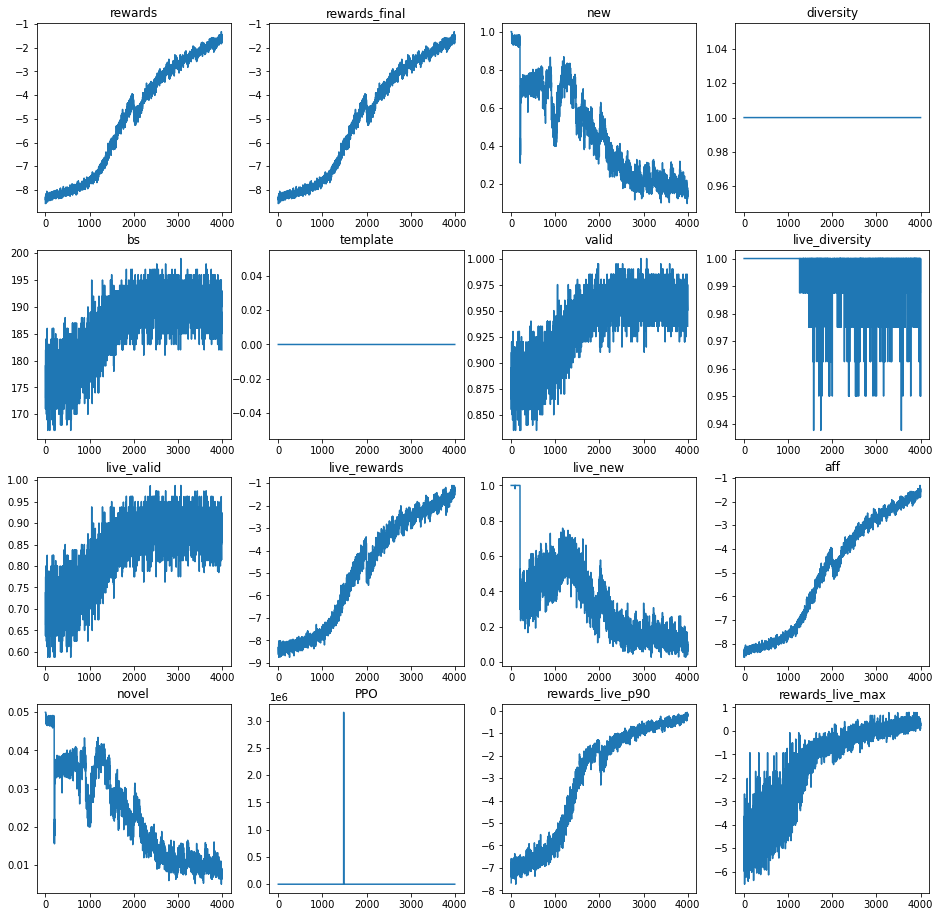

In [23]:
env.log.plot_metrics()

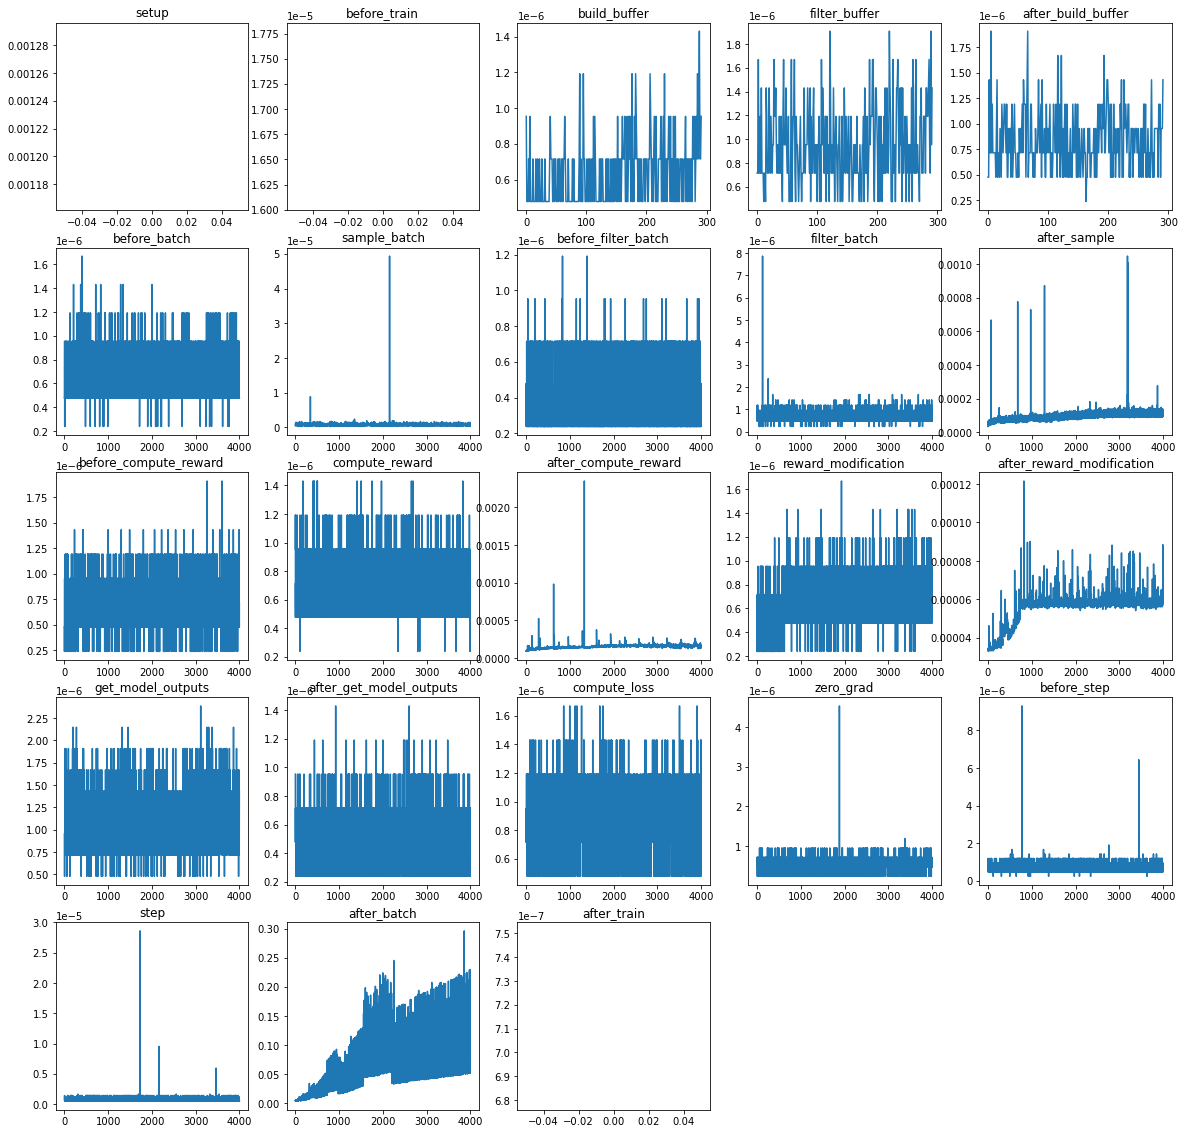

In [24]:
env.log.plot_time(cols=5)

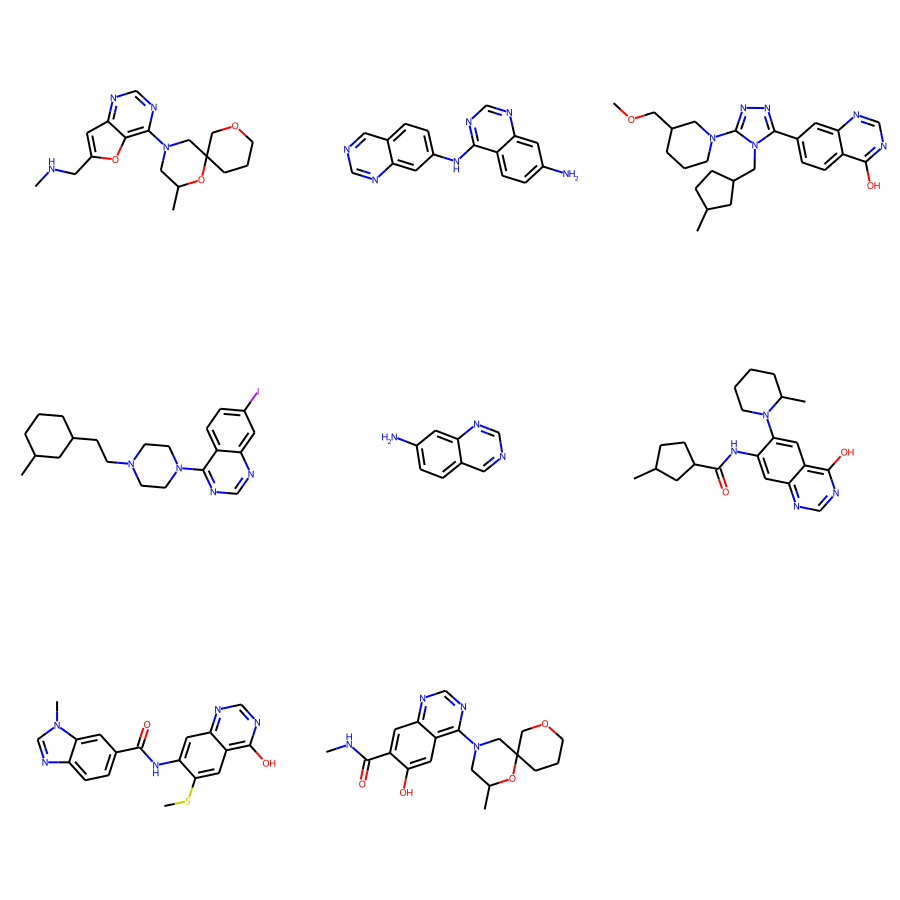

In [25]:
draw_mols(to_mols(env.log.df[env.log.df.aff>0.6].samples.values))

### Conditional LSTM LM Latent Optimization

In [10]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB, prefunc=remove_stereo)

ds = Vec_To_Text_Dataset(['C'], vocab, ECFP6)
supervised_loss = CrossEntropy()


encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']
norm_latent = True

model = Conditional_LSTM_LM(encoder, 
                               d_vocab, 
                               d_embedding, 
                               d_hidden, 
                               d_latent, 
                               n_layers,
                               input_dropout, 
                               lstm_dropout, 
                               norm_latent,
                               condition_hidden, 
                               condition_output, 
                               bos_idx)

model.load_state_dict(torch.load('../nbs/untracked_files/fp_cond_lstm_lm_zinc.pt'))

<All keys matched successfully>

In [11]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-6},
                       base_update_iter=5, base_update=.97)

In [12]:
os.environ['ncpus'] = '16'

In [13]:
agent.update_dataset_from_inputs(temp_df.smiles.values[:1000000])

In [14]:
agent.train_supervised(1000, 1, 5e-5)

Epoch,Train Loss,Valid Loss,Time
0,0.02298,0.01821,03:42


In [15]:
agent.base_model.load_state_dict(agent.model.state_dict())

<All keys matched successfully>

In [16]:
os.environ['ncpus'] = '0'
refresh_global_pool()

In [17]:
freeze(agent.model)

In [18]:
latents = torch.randn((400, 512))
gen_bs = 1500

sampler = LatentSampler(vocab, agent.model, latents, 'latent', 0, 1., gen_bs, opt_kwargs={'lr':1e-3})

samplers = [sampler]

In [19]:
live_max = MaxCallback('rewards', 'latent')
live_p90 = PercentileCallback('rewards', 'latent', 90)

cbs = [live_p90, live_max]

In [20]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], loss_cbs=[loss],
                 cbs=cbs)

In [23]:
env.fit(200, 90, 2000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,latent_diversity,latent_valid,latent_rewards,latent_new,aff,PPO,rewards_latent_p90,rewards_latent_max
0,-8.179,-8.179,1.000,1.000,145,0.000,0.725,1.000,0.725,-8.179,1.000,-8.179,0.298,-6.738,-4.225
10,-8.148,-8.148,0.984,1.000,129,0.000,0.650,0.995,0.648,-8.148,0.984,-8.148,0.351,-6.677,-5.037
20,-8.271,-8.271,0.986,1.000,145,0.000,0.725,1.000,0.725,-8.271,0.986,-8.271,0.227,-6.928,-4.833
30,-8.276,-8.276,0.987,1.000,150,0.000,0.750,1.000,0.750,-8.276,0.987,-8.276,0.211,-6.848,-5.892
40,-8.274,-8.274,0.992,1.000,133,0.000,0.665,1.000,0.665,-8.274,0.992,-8.274,0.265,-7.005,-4.516
50,-8.172,-8.172,0.979,1.000,145,0.000,0.725,1.000,0.725,-8.172,0.979,-8.172,0.300,-6.573,-4.675
60,-8.127,-8.127,0.959,1.000,146,0.000,0.730,1.000,0.730,-8.127,0.959,-8.127,0.304,-6.618,-5.030
70,-8.275,-8.275,0.969,1.000,131,0.000,0.655,1.000,0.655,-8.275,0.969,-8.275,0.268,-6.976,-4.870
80,-8.382,-8.382,0.965,1.000,144,0.000,0.720,1.000,0.720,-8.382,0.965,-8.382,0.263,-7.097,-4.815
90,-8.063,-8.063,0.980,1.000,148,0.000,0.740,1.000,0.740,-8.063,0.980,-8.063,0.302,-6.476,-3.077


In [24]:
env.fit(200, 90, 2000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,latent_diversity,latent_valid,latent_rewards,latent_new,aff,PPO,rewards_latent_p90,rewards_latent_max
2000,-7.443,-7.443,0.606,1.000,132,0.000,0.660,1.000,0.660,-7.443,0.606,-7.443,0.350,-5.589,-3.378
2010,-7.565,-7.565,0.775,1.000,138,0.000,0.695,0.995,0.693,-7.565,0.775,-7.565,0.378,-5.694,-2.710
2020,-7.363,-7.363,0.659,1.000,129,0.000,0.650,0.995,0.648,-7.363,0.659,-7.363,0.378,-5.254,-3.090
2030,-7.331,-7.331,0.653,1.000,124,0.000,0.635,0.985,0.629,-7.331,0.653,-7.331,0.351,-5.378,-3.390
2040,-7.401,-7.401,0.671,1.000,152,0.000,0.760,1.000,0.760,-7.401,0.671,-7.401,0.336,-5.375,-3.245
2050,-7.419,-7.419,0.709,1.000,141,0.000,0.705,1.000,0.705,-7.419,0.709,-7.419,0.449,-5.429,-2.946
2060,-7.358,-7.358,0.767,1.000,146,0.000,0.730,1.000,0.730,-7.358,0.767,-7.358,0.464,-5.035,-3.037
2070,-7.428,-7.428,0.690,1.000,145,0.000,0.730,0.995,0.729,-7.428,0.690,-7.428,0.323,-5.645,-4.024
2080,-7.319,-7.319,0.641,1.000,131,0.000,0.660,0.995,0.658,-7.319,0.641,-7.319,0.383,-5.224,-3.245
2090,-7.399,-7.399,0.626,1.000,115,0.000,0.580,0.995,0.578,-7.399,0.626,-7.399,0.327,-5.522,-3.302


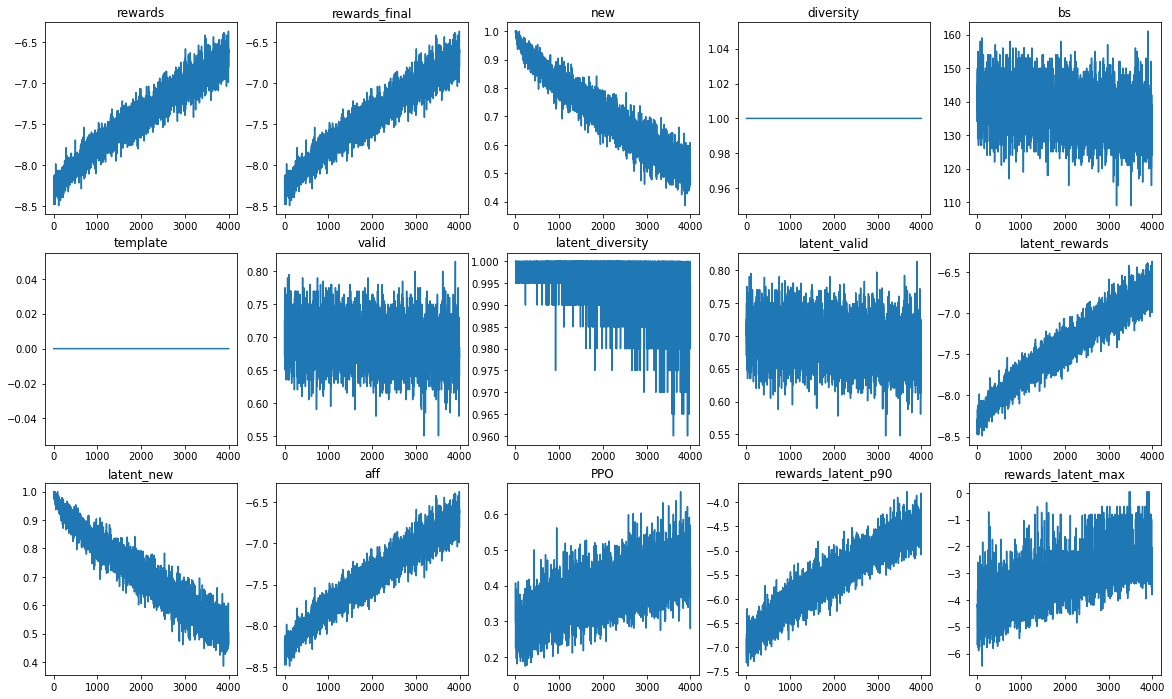

In [25]:
env.log.plot_metrics(cols=5)

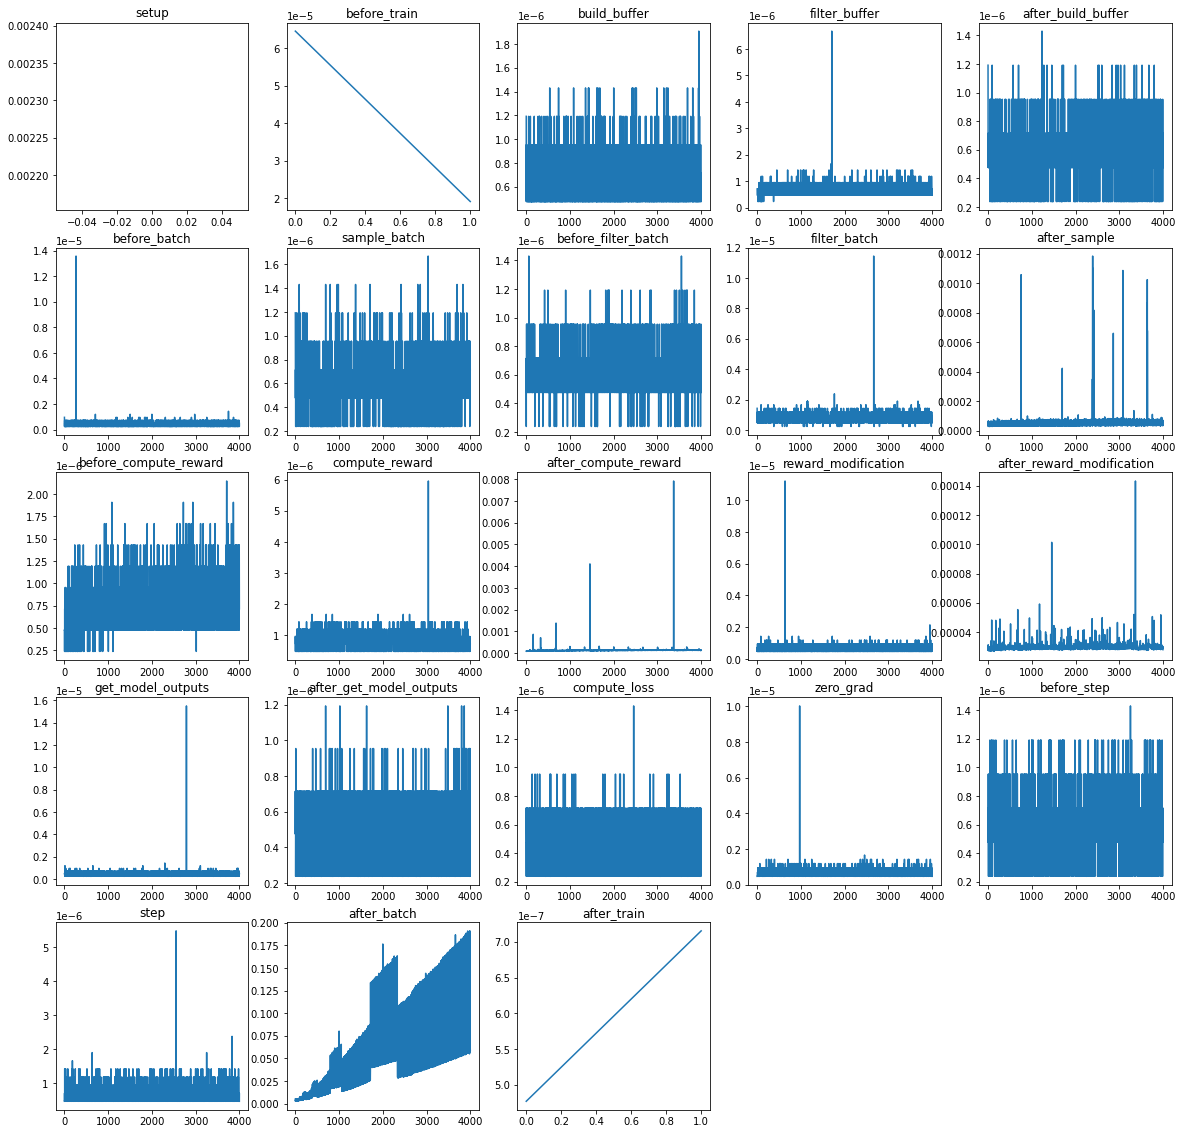

In [26]:
env.log.plot_time(cols=5)

### Conditional LSTM LM Prior Optimization

In [10]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB, prefunc=remove_stereo)

ds = Vec_To_Text_Dataset(['C'], vocab, ECFP6)
supervised_loss = CrossEntropy()


encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']
norm_latent = True

model = Conditional_LSTM_LM(encoder, 
                               d_vocab, 
                               d_embedding, 
                               d_hidden, 
                               d_latent, 
                               n_layers,
                               input_dropout, 
                               lstm_dropout, 
                               norm_latent,
                               condition_hidden, 
                               condition_output, 
                               bos_idx)

model.load_state_dict(torch.load('../nbs/untracked_files/fp_cond_lstm_lm_zinc.pt'))

<All keys matched successfully>

In [11]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-3},
                       base_update_iter=5, base_update=.97)

In [12]:
os.environ['ncpus'] = '16'

agent.update_dataset_from_inputs(temp_df.smiles.values[:1000000])

agent.train_supervised(1000, 1, 5e-5)

agent.base_model.load_state_dict(agent.model.state_dict())

os.environ['ncpus'] = '0'
refresh_global_pool()

Epoch,Train Loss,Valid Loss,Time
0,0.02298,0.01821,03:40


In [13]:
freeze(agent.model.encoder)
freeze(agent.model.decoder)

In [14]:
gen_bs = 1500

samplers = []

num_priors = 3

for i in range(num_priors):
    prior = SphericalPrior(torch.zeros((model.encoder.d_latent)), 
                                torch.zeros((model.encoder.d_latent)), 
                                trainable=True)
    
    prior_loss = PriorLoss(prior)
    
    sampler = PriorSampler(vocab, agent.model, prior, f'prior_{i}', 0, 1/num_priors, 
                           gen_bs, track=False, track_losses=True,
                       train=True, train_all=False, prior_loss=prior_loss, opt_kwargs={'lr':5e-3})
    samplers.append(sampler)

In [15]:
samplers

[prior_0, prior_1, prior_2]

In [16]:
cbs = [PercentileCallback('rewards', f'prior_{i}', 90) for i in range(3)]

In [17]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], 
                  loss_cbs=[], cbs=cbs)

In [18]:
env.fit(200, 90, 2000, 20)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,prior_0_loss,prior_1_loss,prior_2_loss,aff,rewards_prior_0_p90,rewards_prior_1_p90,rewards_prior_2_p90
0,-8.287,-8.287,1.000,1.000,145,0.000,0.732,-1.123,0.221,-2.124,-8.287,-6.952,-7.018,-7.220
20,-8.313,-8.313,1.000,1.000,140,0.000,0.707,-0.668,0.398,-0.827,-8.313,-7.530,-6.996,-6.704
40,-8.199,-8.199,1.000,1.000,139,0.000,0.702,-0.755,1.116,0.543,-8.199,-7.024,-6.775,-6.755
60,-8.300,-8.300,1.000,1.000,124,0.000,0.626,0.681,0.158,0.593,-8.300,-7.224,-7.042,-6.868
80,-8.327,-8.327,1.000,1.000,124,0.000,0.626,-0.623,-0.217,-0.205,-8.327,-6.705,-5.767,-7.539
100,-8.057,-8.057,1.000,1.000,132,0.000,0.667,-0.766,-0.325,-0.016,-8.057,-6.412,-7.055,-7.100
120,-8.132,-8.132,1.000,1.000,131,0.000,0.662,-0.546,0.546,-0.991,-8.132,-7.146,-6.710,-5.943
140,-8.190,-8.190,1.000,1.000,135,0.000,0.682,0.181,-0.946,-0.405,-8.190,-7.335,-6.923,-6.884
160,-8.178,-8.178,1.000,1.000,141,0.000,0.712,1.825,-0.176,-0.269,-8.178,-6.412,-7.042,-6.951
180,-8.058,-8.058,1.000,1.000,141,0.000,0.712,0.932,-0.470,-1.265,-8.058,-6.413,-7.309,-6.184


In [40]:
for sampler in samplers:
    prior = sampler.prior
    prior.log_scale.data = torch.clamp(prior.log_scale.data, -1, 1)

In [42]:
env.fit(200, 90, 2000, 20)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,prior_0_loss,prior_1_loss,prior_2_loss,aff,rewards_prior_0_p90,rewards_prior_1_p90,rewards_prior_2_p90
2000,-4.323,-4.323,0.326,1.000,138,0.000,0.722,9.220,4.234,9.844,-4.323,-2.196,-2.456,-1.290
2020,-4.609,-4.609,0.362,1.000,138,0.000,0.737,-2.126,0.958,-0.843,-4.609,-2.251,-3.020,-1.489
2040,-4.764,-4.764,0.320,1.000,128,0.000,0.697,2.374,1.778,4.477,-4.764,-2.900,-3.086,-1.988
2060,-4.605,-4.605,0.326,1.000,132,0.000,0.712,10.000,-10.000,0.447,-4.605,-2.617,-3.151,-1.116
2080,-4.224,-4.224,0.281,1.000,128,0.000,0.692,10.000,-7.761,-2.128,-4.224,-2.365,-2.186,-1.489
2100,-4.485,-4.485,0.315,1.000,146,0.000,0.798,10.000,10.000,-0.492,-4.485,-2.603,-2.857,-1.395
2120,-4.324,-4.324,0.270,1.000,141,0.000,0.778,10.000,-9.992,-5.816,-4.324,-2.242,-2.417,-1.133
2140,-4.659,-4.659,0.319,1.000,138,0.000,0.773,-10.000,-8.132,0.563,-4.659,-3.278,-3.228,-0.797
2160,-4.258,-4.258,0.341,1.000,132,0.000,0.702,-10.000,-10.000,-0.779,-4.258,-2.691,-2.846,-0.952
2180,-4.353,-4.353,0.319,1.000,141,0.000,0.778,-10.000,10.000,-5.178,-4.353,-2.622,-2.459,-1.192


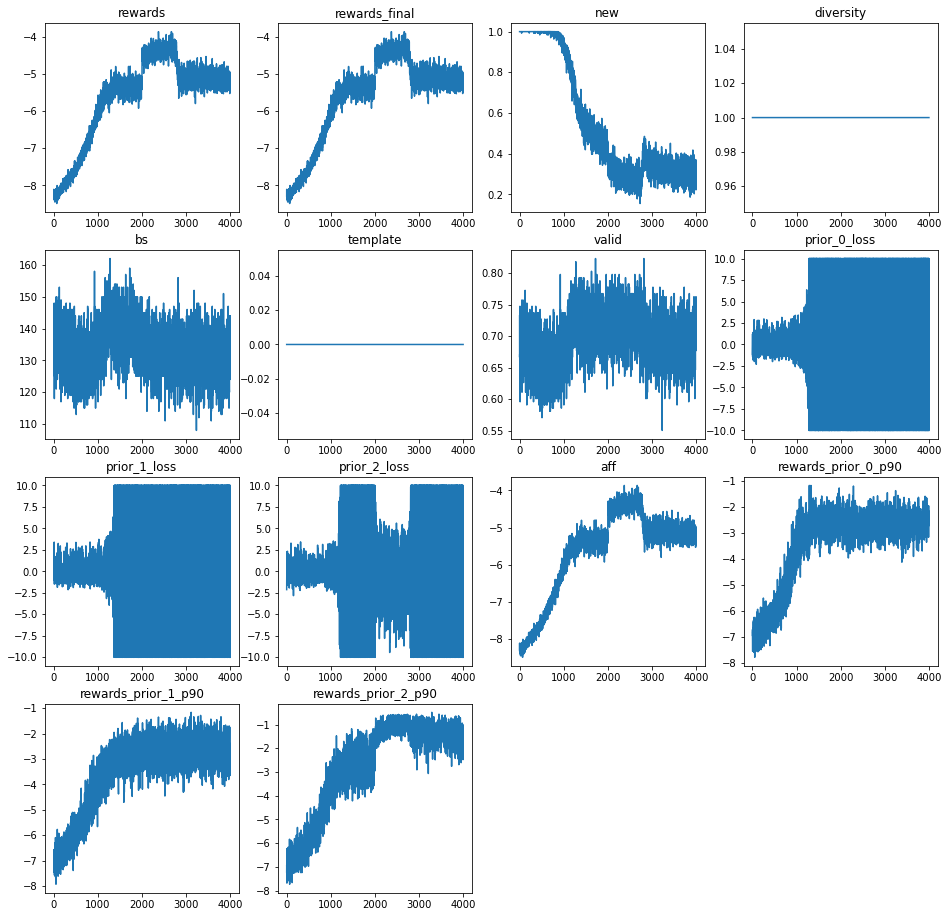

In [43]:
env.log.plot_metrics()

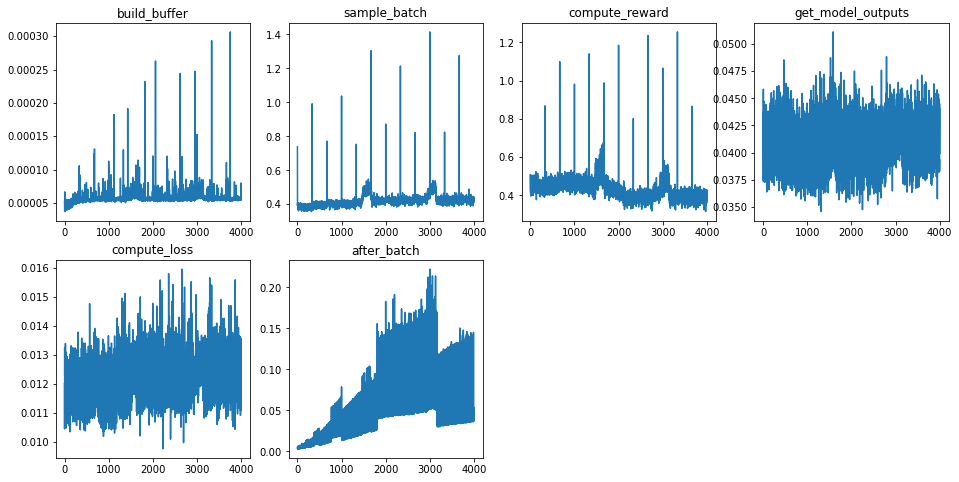

In [44]:
env.log.plot_timelog()

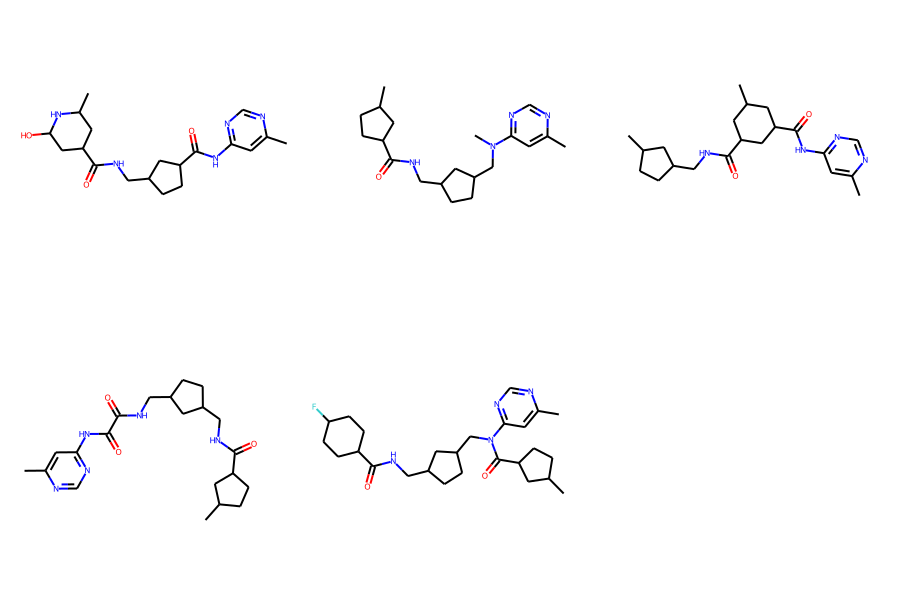

In [46]:
draw_mols(to_mols(env.log.df[env.log.df.aff>0.4].samples.values))

In [47]:
log_df = env.log.get_df()

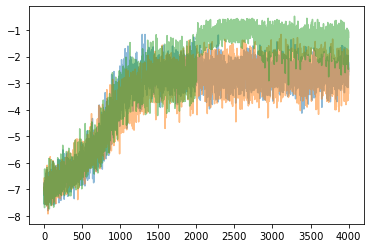

In [64]:
plt.plot(log_df[log_df.sources=='prior_0'].groupby('batch')['rewards'].quantile(.9).values, alpha=0.5)
plt.plot(log_df[log_df.sources=='prior_1'].groupby('batch')['rewards'].quantile(.9).values, alpha=0.5)
plt.plot(log_df[log_df.sources=='prior_2'].groupby('batch')['rewards'].quantile(.9).values, alpha=0.5)

### Conditional LSTM LM Contrastive

In [10]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB, prefunc=remove_stereo)

# ds = Vec_To_Text_Dataset(['C'], vocab, ECFP6)
ds = Vec_To_Text_Dataset([('CCC', '')], vocab, partial(failsafe_fp, fp_function=ECFP6))
supervised_loss = CrossEntropy()


encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']
norm_latent = True

model = Conditional_LSTM_LM(encoder, 
                               d_vocab, 
                               d_embedding, 
                               d_hidden, 
                               d_latent, 
                               n_layers,
                               input_dropout, 
                               lstm_dropout, 
                               norm_latent,
                               condition_hidden, 
                               condition_output, 
                               bos_idx)

model.load_state_dict(torch.load('../nbs/untracked_files/fp_cond_lstm_lm_zinc.pt'))

<All keys matched successfully>

In [11]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':1e-4},
                       base_update_iter=5, base_update=.97)

In [12]:
agent.update_dataset_from_inputs(temp_df.smiles.values[:1000000])

In [13]:
os.environ['ncpus'] = '12'
agent.train_supervised(500, 1, 5e-5)
os.environ['ncpus'] = '0'

Epoch,Train Loss,Valid Loss,Time
0,0.02069,0.01481,03:47


In [14]:
agent.base_model.load_state_dict(agent.model.state_dict())

<All keys matched successfully>

In [15]:
refresh_global_pool()

In [16]:
gen_bs = 1500

# data_df = next(pd.read_csv('/home/dmai/smiles_datasets/shard_0.csv', chunksize=1000000))
# sampler1 = DatasetSampler(data_df.smiles.values, 2000, 'zinc_data')
sampler1 = DatasetSampler(temp_df.smiles.values[:1000000], 2000, 'zinc_data')
sampler1 = ContrastiveSampler(sampler1, vocab, ds, agent.model, gen_bs, repeats=6)

sampler2 = LogSampler('samples', 'rewards', 50, 95, 500)

samplers = [sampler1, sampler2]

In [17]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)

cbs = [supervised_cb]

In [18]:
template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 8),
                     ChargeFilter(None, 0)],
                    [], 
                    fail_score=-10., log=False)

sf = FPSimilarity(partial(failsafe_fp, fp_function=ECFP6), tanimoto_rd, 0.2, 0.95, 0.05, -1.)
template_cb = ContrastiveTemplate(sf, max_score=2., template=template, prefilter=True)

In [19]:
contrastive_reward = ContrastiveReward(aff_reward)

In [20]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[contrastive_reward], loss_cbs=[loss],
                 cbs=cbs)

In [21]:
refresh_global_pool()

In [22]:
env.fit(200, 90, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,template_temp,template_sim,valid,aff,PPO
0,0.037,0.037,1.000,1.000,200,0.050,0.000,0.050,1.000,-0.013,0.441
10,0.071,0.071,1.000,1.000,200,0.050,0.000,0.050,1.000,0.021,0.362
20,-0.011,-0.011,1.000,1.000,200,0.050,0.000,0.050,1.000,-0.061,0.867
30,0.122,0.122,1.000,1.000,200,0.050,0.000,0.050,1.000,0.072,2.001
40,0.046,0.046,1.000,1.000,200,0.050,0.000,0.050,1.000,-0.004,1.665
50,0.181,0.181,1.000,1.000,200,0.050,0.000,0.050,1.000,0.131,0.778
60,0.430,0.430,0.865,1.000,200,0.050,0.000,0.050,1.000,0.380,14.910
70,0.363,0.363,0.870,1.000,200,0.050,0.000,0.050,1.000,0.313,1.578
80,0.419,0.419,0.875,1.000,200,0.050,0.000,0.050,1.000,0.369,0.527
90,0.180,0.180,0.895,1.000,200,0.050,0.000,0.050,1.000,0.130,4.551


Epoch,Train Loss,Valid Loss,Time
0,0.25805,0.18333,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.29657,0.25787,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.21762,0.24431,00:05


Epoch,Train Loss,Valid Loss,Time
0,0.30869,0.16743,00:07


Epoch,Train Loss,Valid Loss,Time
0,0.27176,0.21140,00:08


In [23]:
env.fit(200, 90, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,template_temp,template_sim,valid,aff,PPO
1000,0.496,0.496,0.895,1.000,200,0.050,0.000,0.050,1.000,0.446,0.755
1010,0.265,0.265,0.930,1.000,200,0.050,0.000,0.050,1.000,0.215,0.695
1020,0.436,0.436,0.885,1.000,200,0.050,0.000,0.050,1.000,0.386,1813.939
1030,0.462,0.462,0.880,1.000,200,0.050,0.000,0.050,1.000,0.412,0.852
1040,0.598,0.598,0.895,1.000,200,0.050,0.000,0.050,1.000,0.548,2.677
1050,0.341,0.341,0.915,1.000,200,0.050,0.000,0.050,1.000,0.291,9.981
1060,0.490,0.490,0.895,1.000,200,0.050,0.000,0.050,1.000,0.440,5.125
1070,0.319,0.319,0.895,1.000,200,0.050,0.000,0.050,1.000,0.269,1.643
1080,0.694,0.694,0.895,1.000,200,0.050,0.000,0.050,1.000,0.644,17.404
1090,0.482,0.482,0.900,1.000,200,0.050,0.000,0.050,1.000,0.432,1.084


Epoch,Train Loss,Valid Loss,Time
0,0.21400,0.32610,00:10


Epoch,Train Loss,Valid Loss,Time
0,0.35777,0.25068,00:12


Epoch,Train Loss,Valid Loss,Time
0,0.22271,0.18754,00:14


Epoch,Train Loss,Valid Loss,Time
0,0.22467,0.17211,00:16


Epoch,Train Loss,Valid Loss,Time
0,0.24160,0.15575,00:18


Process ForkPoolWorker-231:
Process ForkPoolWorker-225:
Process ForkPoolWorker-232:
Process ForkPoolWorker-229:
Process ForkPoolWorker-230:
Process ForkPoolWorker-233:
Process ForkPoolWorker-227:
Process ForkPoolWorker-228:
Process ForkPoolWorker-226:
Process ForkPoolWorker-234:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


In [28]:
env.log.df[env.log.df.aff>7]

,samples,sources,rewards,rewards_final,template,template_temp,template_sim,aff,PPO
27304,(CC[C@@H]1C[C@H](C(=O)N2CCc3c(ncn3CCc3ccccc3)C...,zinc_data_buffer,7.160080,7.160080,0.05,0.0,0.05,7.110080,4.291091
194419,"(c1cc2cc(-c3noc(C[C@@H]4CCOC4)n3)ccc2cn1, c1cc...",zinc_data_buffer,7.207475,7.207475,0.05,0.0,0.05,7.157475,5.539962
295938,"(FC(F)(F)c1cnc(-c2ccc3ccccc3n2)cn1, FC(F)(F)c1...",zinc_data_buffer,7.361365,7.361365,0.05,0.0,0.05,7.311365,1.532705
304088,(CO[C@]12CCC[C@@]1(C(=O)N1CCC(Cc3ncc[nH]3)CC1)...,zinc_data_buffer,8.286204,8.286204,0.05,0.0,0.05,8.236204,8.588727
306981,"(O=C(NCCc1cc2ccccc2[nH]1)[C@H]1CCCC(F)(F)C1, O...",zinc_data_buffer,7.382399,7.382399,0.05,0.0,0.05,7.332398,4.622929
347080,(CO[C@@H]1CN([C@@H]2CCCNC2=O)C[C@H]1NC(=O)c1cc...,zinc_data_buffer,7.121587,7.121587,0.05,0.0,0.05,7.071587,2.940111
353628,"(O=C(/C=C\c1ccc(O)cc1)NC[C@@H](O)Cc1cccc(F)c1,...",zinc_data_buffer,7.437281,7.437281,0.05,0.0,0.05,7.387280,6.867351
356293,(CC(C)(C)[C@@]1(CN)CCN(C(=O)C(=O)NCCC2=CCCCC2)...,zinc_data_buffer,7.682295,7.682295,0.05,0.0,0.05,7.632295,6.298365


In [57]:
samples = env.log.df[env.log.df.aff>7].samples.values
sources = [i[0] for i in samples]
targets = [i[1] for i in samples]
source_scores = [aff_reward.reward.weight*aff_reward.reward.score_log[i] for i in sources]
target_scores = [aff_reward.reward.weight*aff_reward.reward.score_log[i] for i in targets]

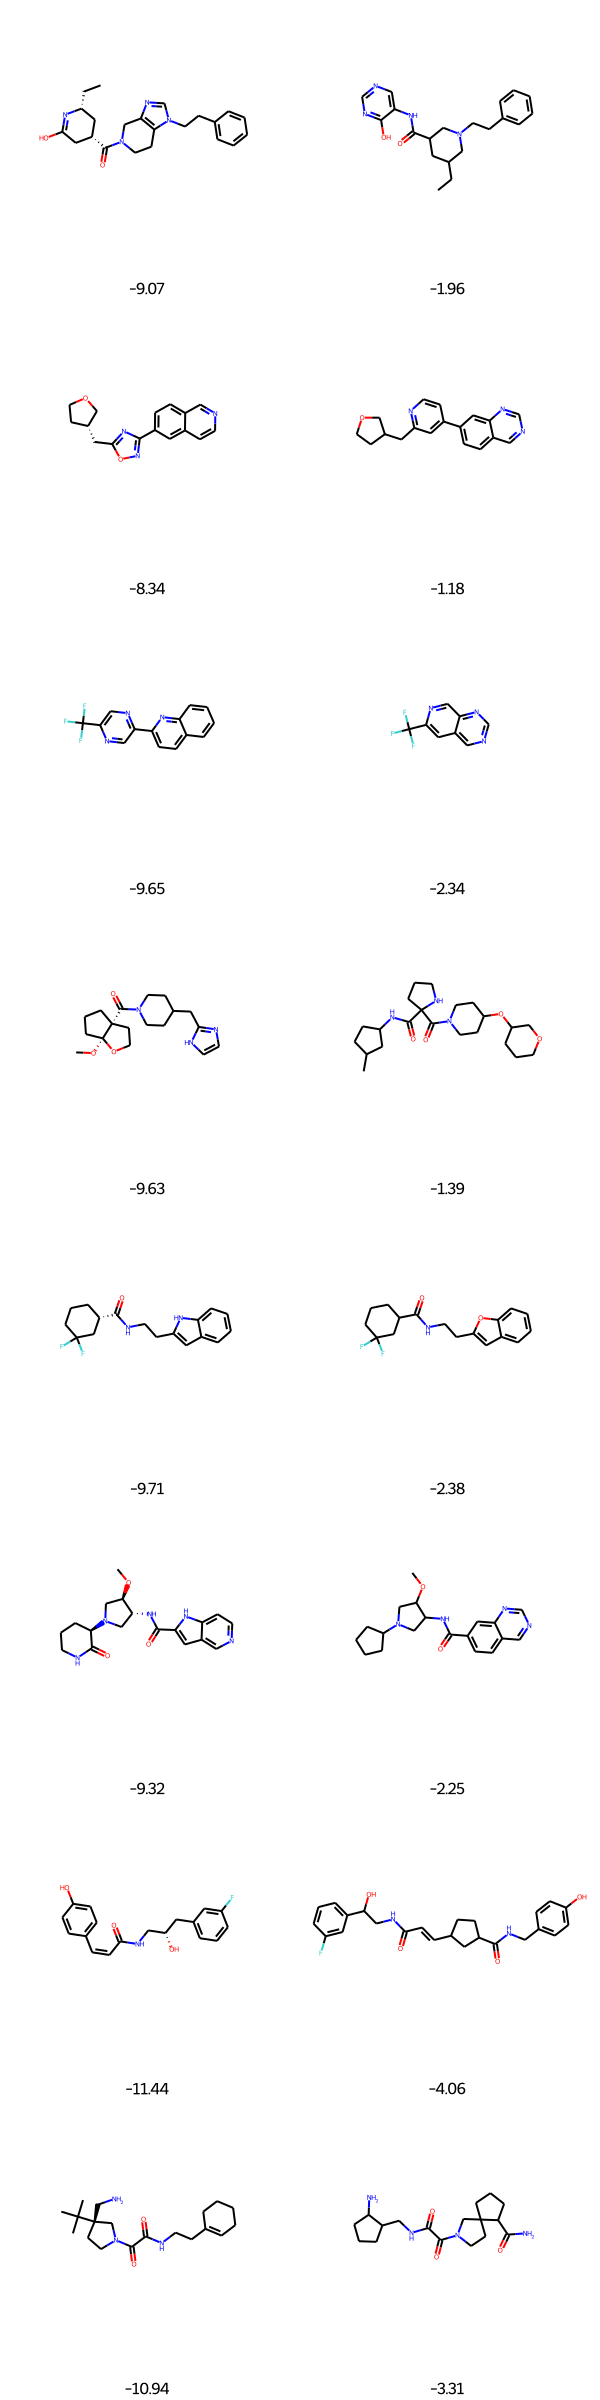

In [58]:
draw_mols(to_mols(flatten_list_of_lists(zip(sources, targets))), mols_per_row=2,
         legends = flatten_list_of_lists(zip([f'{i.item():.2f}' for i in source_scores],
                                        [f'{i.item():.2f}' for i in target_scores])))

In [59]:
samples = temp_df.sample(n=100).smiles.values
sampler1.repeats = 20
new_samples = sampler1.sample_outputs(samples, 90)
sampler1.repeats = 5

In [61]:
source_scores = aff_reward.reward([i[0] for i in new_samples])
target_scores = aff_reward.reward([i[1] for i in new_samples])

In [62]:
(target_scores - source_scores).max()

tensor(5.7071, device='cuda:1')

In [64]:
pred_df = pd.DataFrame([i[0] for i in new_samples], columns=['source'])
pred_df['target'] = [i[1] for i in new_samples]
pred_df['source_scores'] = source_scores.detach().cpu().numpy()
pred_df['target_scores'] = target_scores.detach().cpu().numpy()
pred_df['diff'] = pred_df.target_scores - pred_df.source_scores

<AxesSubplot:>

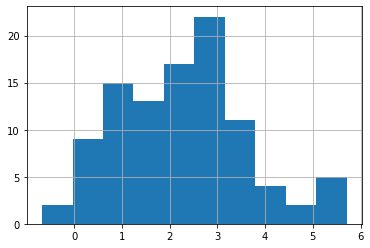

In [65]:
pred_df.groupby('source')['diff'].max().hist()

(-10.837664103507995, -2.418505322933197)

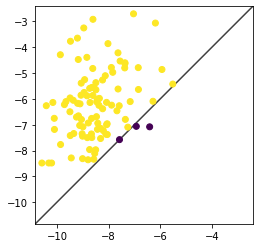

In [69]:
source_vals = pred_df.groupby('source')['source_scores'].max()
target_vals = pred_df.groupby('source')['target_scores'].max()

fig, ax = plt.subplots()

ax.scatter(source_vals,
            target_vals,
            c=(target_vals>source_vals))

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

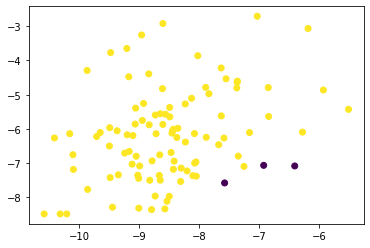

In [70]:
source_vals = pred_df.groupby('source')['source_scores'].max()
target_vals = pred_df.groupby('source')['target_scores'].max()

plt.scatter(source_vals,
            target_vals,
            c=(target_vals>source_vals))

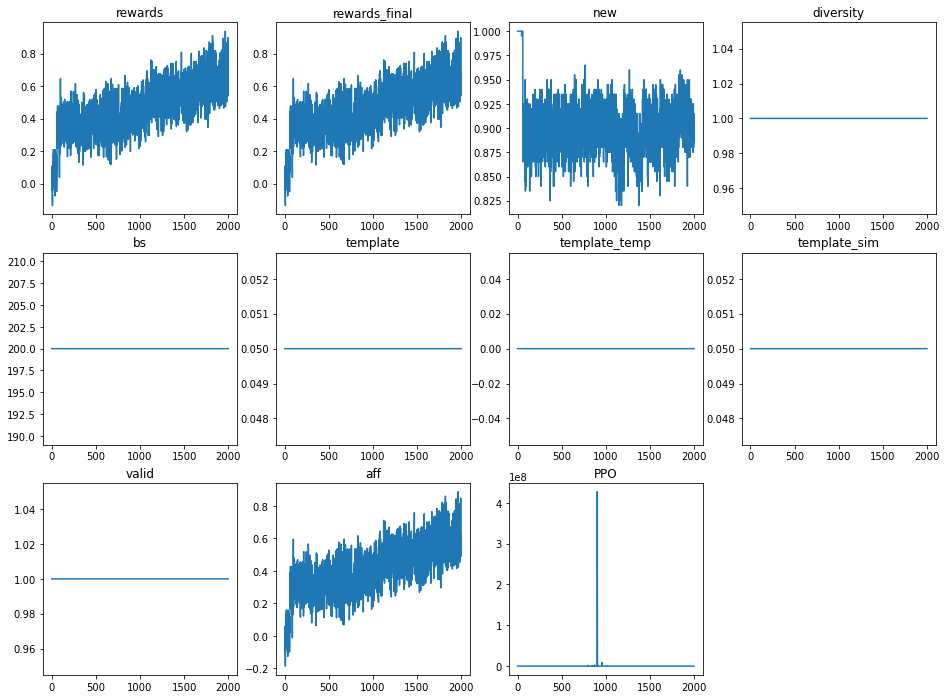

In [71]:
env.log.plot_metrics()

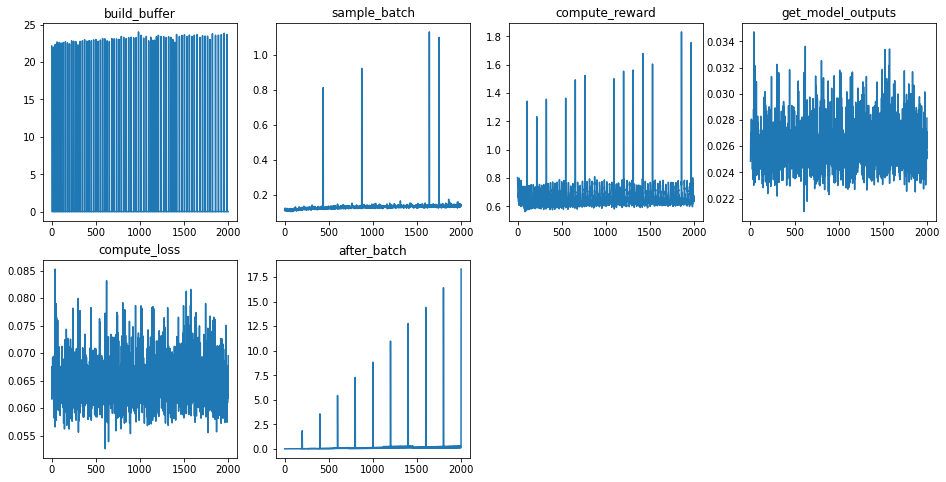

In [72]:
env.log.plot_timelog()

## LSTM R Group

In [10]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB, prefunc=remove_stereo)

ds = Text_Dataset(['C'], vocab)
supervised_loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_rgroup.pt'))

<All keys matched successfully>

In [11]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-6},
                       base_update_iter=5, base_update=.97)

In [12]:
reference = 'O=C(CCCCCCn1cc(-c2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)nn1)NO'
scaffold = '*c1ccc2ncnc(Nc3cccc(Cl)c3F)c2c1'

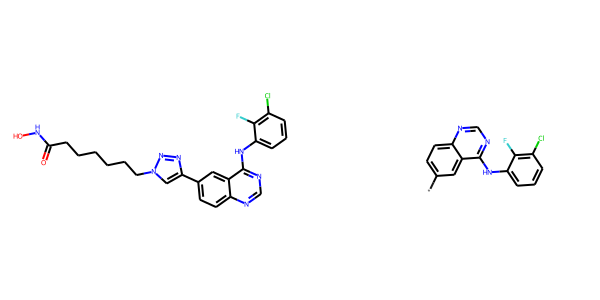

In [13]:
draw_mols(to_mols([reference, scaffold]))

In [14]:
r_template = Template(
                    [MolWtFilter(20, 200),
                     RingFilter(1,2)],
                    [],
                    fail_score=-1, log=False
                    )

smarts = ['[#6](=[#16])(-[#7])-[#7]',
        '[H]-[#6](-[H])=[#6]-[*]',
        '[#6]=[#6]=[#6]',
        '[#7][F,Cl,Br,I]',
        '[#6;!R]=[#6;!R]-[#6;!R]=[#6;!R]']



full_template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 8),
                     HeteroatomFilter(None, 10),
                     ChargeFilter(None, 0),
                     MaxRingFilter(None, 6),
                     MinRingFilter(5, None),
                     HBDFilter(None, 5),
                     HBAFilter(None, 10),
                     MolWtFilter(None, 500),
                     LogPFilter(None, 5),
                     SAFilter(None, 7),
                     BridgeheadFilter(None,0),
                     PAINSAFilter(),
                     ExclusionFilter(smarts, criteria='any'),
                     RotChainFilter(None, 7)
                    ],
                    [], 
                    fail_score=-10., log=False, use_lookup=True)

template = RGroupBlockTemplate(scaffold, r_template, 
                                    full_molecule_template=full_template)

template_cb = TemplateCallback(template, prefilter=True)

In [15]:
# df = pd.read_csv('../../smiles_datasets/single_frags.csv')
# df = df[df.weight<175]

# os.environ['ncpus'] = '64'
# screened = template.recurse_fragments(df.smiles.values)
# os.environ['ncpus'] = '0'

# screened = [i for i in screened if i[2]]

# screened = [i[0] for i in screened]
# screened = [i.replace('[2*:1]', '*') for i in screened]

# screened = list(set(screened))

# df = pd.DataFrame(screened, columns=['smiles'])
# df.to_csv('rgroup_screened.csv', index=False)

In [16]:
df = pd.read_csv('rgroup_screened.csv')
agent.update_dataset_from_inputs(df.smiles.values)
agent.train_supervised(128, 3, 5e-5)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.53544,0.47706,00:54
1,0.48897,0.47315,00:54
2,0.49225,0.47271,00:54


<All keys matched successfully>

In [17]:
refresh_global_pool()

In [18]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.4, gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('samples', 'rewards', 10, 95, 100, vocab, 0.1)

samplers = [sampler1, sampler2, sampler3, sampler4]

In [19]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)
retrain_cb = ResetAndRetrain(agent, 2000, '../nbs/untracked_files/lstm_lm_rgroup.pt',
               90, 5e-5, 64, 3)
new_cb = NoveltyReward(weight=0.05)

cbs = [new_cb, supervised_cb, live_p90, live_max, retrain_cb]

In [20]:
aff_reward = RewardCallback(reward, 'aff', sample_name='samples_fused')

In [21]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], loss_cbs=[loss],
                 cbs=cbs)

In [22]:
%%time
env.fit(200, 45, 4000, 20)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,novel,PPO,rewards_live_p90,rewards_live_max
0,-4.930,-4.930,1.000,1.000,152,0.000,0.760,1.000,0.400,-4.504,1.000,-4.930,0.050,0.724,-3.181,-1.708
20,-4.644,-4.644,0.923,1.000,156,0.000,0.780,1.000,0.450,-4.847,0.972,-4.644,0.046,0.611,-3.043,-1.069
40,-4.432,-4.432,0.884,1.000,146,0.000,0.730,1.000,0.325,-4.314,0.923,-4.432,0.044,0.517,-2.477,-1.007
60,-4.733,-4.733,0.862,1.000,152,0.000,0.760,1.000,0.400,-4.994,1.000,-4.733,0.043,0.738,-3.073,-2.170
80,-4.580,-4.580,0.805,1.000,159,0.000,0.795,1.000,0.487,-4.917,0.923,-4.580,0.040,0.725,-3.052,-1.615
100,-4.622,-4.622,0.803,1.000,157,0.000,0.785,1.000,0.463,-4.935,0.919,-4.622,0.040,0.627,-3.579,-2.222
120,-4.577,-4.577,0.829,1.000,152,0.000,0.760,1.000,0.400,-4.950,0.969,-4.577,0.041,0.680,-3.046,-1.733
140,-4.502,-4.502,0.863,1.000,153,0.000,0.765,1.000,0.412,-4.655,0.970,-4.502,0.043,0.571,-2.751,-2.287
160,-4.655,-4.655,0.835,1.000,158,0.000,0.790,1.000,0.475,-5.012,0.868,-4.655,0.042,0.549,-2.871,-1.502
180,-4.290,-4.290,0.764,1.000,148,0.000,0.740,1.000,0.350,-4.582,0.929,-4.290,0.038,0.638,-2.757,-0.830


Epoch,Train Loss,Valid Loss,Time
0,0.50855,0.55960,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.41709,0.56845,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.43557,0.39327,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.42894,0.40098,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.48824,0.36650,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.39625,0.47634,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.37903,0.41070,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.36871,0.38051,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.36355,0.39030,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.45055,0.38868,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.47402,0.45152,00:02
1,0.43634,0.41578,00:02
2,0.44338,0.41300,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.35385,0.38974,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.43583,0.56681,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.38276,0.36612,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.33657,0.38093,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.35629,0.33915,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.47225,0.37534,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.34903,0.33902,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.35106,0.37044,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.30014,0.32696,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.34234,0.31994,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.44116,0.42393,00:03
1,0.39563,0.39268,00:03
2,0.35815,0.38889,00:03


CPU times: user 11h 55min 39s, sys: 13min 58s, total: 12h 9min 38s
Wall time: 37min 8s


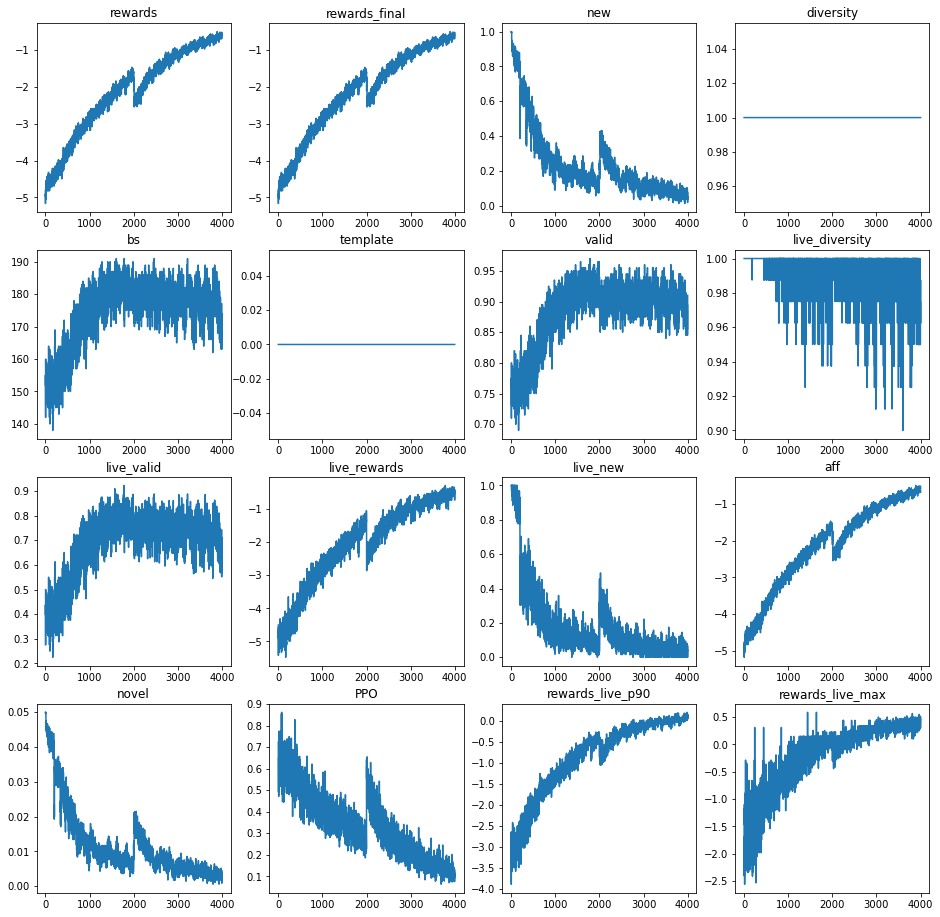

In [23]:
env.log.plot_metrics()

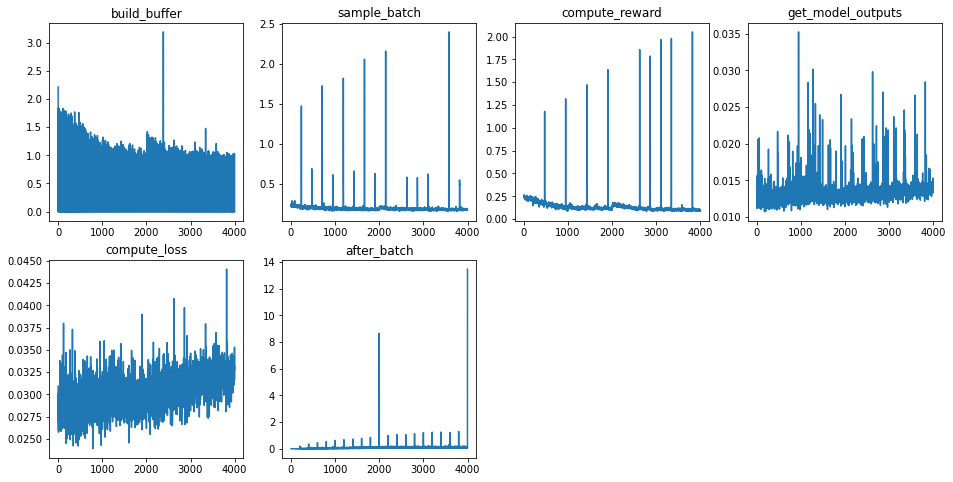

In [24]:
env.log.plot_timelog()

In [27]:
ref_reward = aff_reward.reward([reference]).item()
ref_reward

0.36748892068862915

In [28]:
log_df = env.log.df
log_df.drop_duplicates(subset='samples', inplace=True)
log_df[log_df.aff>ref_reward]

,samples,sources,rewards,rewards_final,template,samples_fused,aff,novel,PPO
94827,*Cc1n[nH]cc1N1CCC(O)C1,live,0.638297,0.588297,0.0,OC1CCN(c2c[nH]nc2Cc2ccc3ncnc(Nc4cccc(Cl)c4F)c3...,0.588297,0.05,0.981848
98215,*Cc1ncnc2c(C(N)=O)ccnc12,base_buffer,0.491350,0.441350,0.0,NC(=O)c1ccnc2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c4c3...,0.441350,0.05,0.057893
141010,*Cc1nc(C(N)=O)nc2c1C(C)OC2,base_buffer,0.482966,0.432966,0.0,CC1OCc2nc(C(N)=O)nc(Cc3ccc4ncnc(Nc5cccc(Cl)c5F...,0.432966,0.05,-0.799075
141720,*Cc1nn(C)c(C(=O)O)c1C=CCO,live_buffer,0.432390,0.382390,0.0,Cn1nc(Cc2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)c(C=CCO)...,0.382390,0.05,-1.207913
141853,*Cc1nn(C)c2c1C(O)CCC2=O,live_buffer,0.473305,0.423305,0.0,Cn1nc(Cc2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)c2c1C(=O...,0.423305,0.05,-0.871654
142351,*Cc1nc(CO)nc(C(N)=O)c1C=[CH],live,0.504036,0.454036,0.0,[CH]=Cc1c(Cc2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)nc(C...,0.454036,0.05,-1.108628
143160,*Cc1nn(CCCN)c2c1C(O)OC2,live,0.551636,0.501635,0.0,NCCCn1nc(Cc2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)c2c1C...,0.501635,0.05,-0.981683
143839,*Cc1nc(C(N)=O)ncc1C=CC[NH-],live_buffer,0.524132,0.474132,0.0,[NH-]CC=Cc1cnc(C(N)=O)nc1Cc1ccc2ncnc(Nc3cccc(C...,0.474132,0.05,-1.242457
143984,*Cc1nc(C)nc(C(N)=O)c1C[NH-],live_buffer,0.438975,0.388975,0.0,Cc1nc(Cc2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)c(C[NH-]...,0.388975,0.05,-1.238878
144181,*Cc1nc(C(N)=O)c(O)cc1[SiH3],base_buffer,0.422934,0.372934,0.0,NC(=O)c1nc(Cc2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)c([...,0.372934,0.05,-1.141315


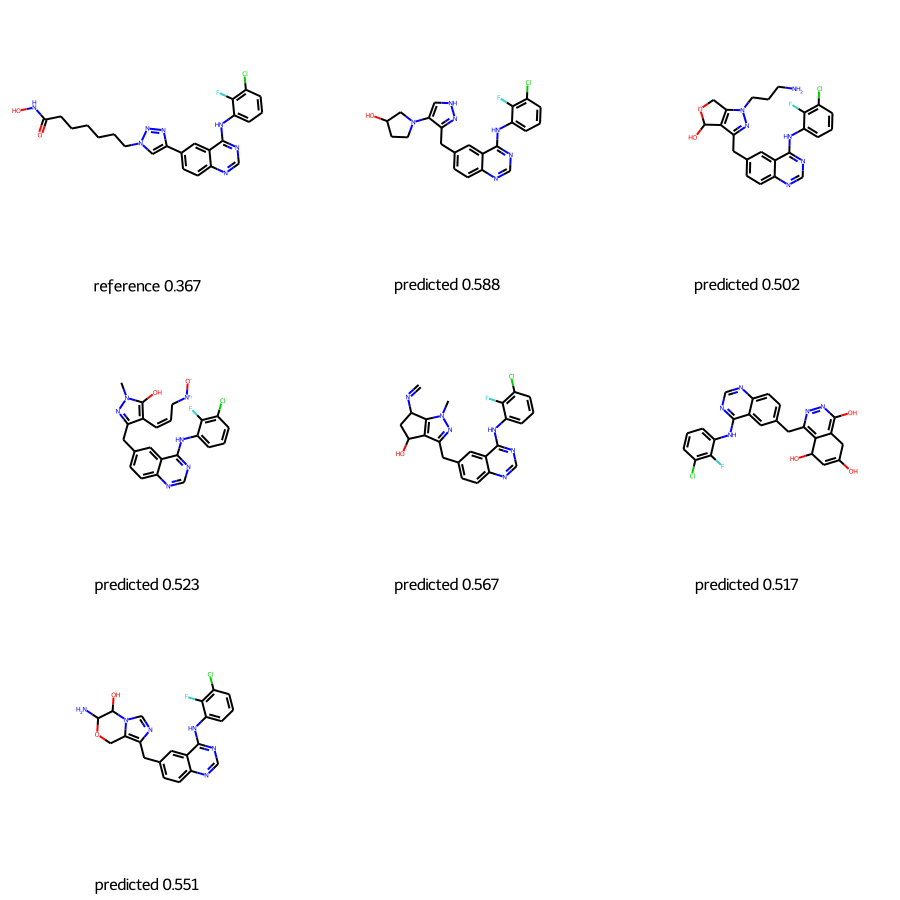

In [32]:
predicted = list(log_df[log_df.aff>0.5].samples_fused.values)
affinities = log_df[log_df.aff>0.5].aff.values
draw_mols(to_mols([reference]+ predicted),
         legends=[f'reference {ref_reward:.3f}']+[f'predicted {affinities[i]:.3f}' for i in range(len(predicted))])

### LSTM LM Beam Search

In [5]:
# os.environ['use_cuda'] = 'cpu'

In [80]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Text_Dataset(['C'], vocab)
supervised_loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc.pt'))

<All keys matched successfully>

In [81]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-6},
                       base_update_iter=5, base_update=.97)

In [82]:
agent.update_dataset_from_inputs(df[df.value<5].smiles.values)
agent.train_supervised(32, 4, 5e-5)

Epoch,Train Loss,Valid Loss,Time
0,0.59993,0.44867,00:02
1,0.29946,0.33333,00:02
2,0.28753,0.30202,00:02
3,0.28034,0.29855,00:02


In [83]:
agent.update_dataset_from_inputs(df[df.value<0].smiles.values)
agent.train_supervised(32, 3, 5e-5)

Epoch,Train Loss,Valid Loss,Time
0,0.26167,0.22664,00:00
1,0.26387,0.22383,00:00
2,0.22908,0.22306,00:00


In [84]:
agent.update_dataset_from_inputs(df[df.value<-2].smiles.values)
agent.train_supervised(32, 3, 5e-5)

Epoch,Train Loss,Valid Loss,Time
0,0.28959,0.41462,00:00
1,0.25885,0.39703,00:00
2,0.24501,0.39703,00:00


In [93]:
k = len(vocab.itos)
beam_size = 300
sl = 90
hiddens = None
temperature = 1.
select_distinct = False

seed_sequence = ''
seed_tokens = vocab.tokenize(seed_sequence)[:-1]

seed_ints = torch.tensor(vocab.numericalize(seed_tokens)).long().unsqueeze(0)

current_device = next(model.parameters()).device

preds = seed_ints.repeat(k,1)
preds = to_device(preds)
idxs = preds[:,-1].unsqueeze(-1)

lps = idxs.new_zeros((k, 1)).float()

with torch.no_grad():
    for i in range(sl):
        x, hiddens, encoded = model._forward(idxs, hiddens)
        x.div_(temperature)
        
        log_probs = F.log_softmax(x, -1)
#         log_probs = log_probs.squeeze(1)
#         indices = torch.multinomial(log_probs.exp(), k)
#         values = torch.gather(log_probs, 1, indices).unsqueeze(1)
        values, indices = log_probs.topk(k, dim=-1)
        
        lps = torch.cat([lps.unsqueeze(-1).repeat(1,1,values.shape[-1]), -values], 1)
        current_sl = lps.shape[1]
        lps = lps.permute(0,2,1).reshape(-1,current_sl)
        
        preds = torch.cat([preds[:,None].expand(preds.size(0), k , preds.size(1)),
                indices.squeeze(1)[:,:,None].expand(preds.size(0), k, 1),], dim=2)
        
        preds = preds.view(-1, preds.size(2))
        
        if select_distinct:
            pred_strs = ['_'.join([str(j) for j in i]) for i in preds.detach().cpu().numpy()]
            pred_strs = [i.split('_2_')[0] for i in pred_strs]
            unique_idxs = (~pd.Series(pred_strs).duplicated()).values
#             unique_idxs = (~pd.Series(agent.reconstruct(preds)).duplicated()).values
#             unique_idxs = (~pd.Series([vocab.reconstruct(i) for i in preds]).duplicated()).values
#             unique_idxs = torch.unique(torch.unique(preds, dim=0, return_inverse=True)[1])
            preds = preds[unique_idxs]
            lps = lps[unique_idxs]
        
        scores = lps.sum(-1)
        indices_idx = torch.arange(0,preds.size(0))[:,None].expand(preds.size(0), k).contiguous().view(-1)
        sort_idx = scores.argsort()[:beam_size]

        preds = preds[sort_idx]
        lps = lps[sort_idx]
        
        idxs = preds[:,-1].unsqueeze(-1)
        hiddens = [(i[0][:, indices_idx[sort_idx], :], i[1][:, indices_idx[sort_idx], :]) for i in hiddens]
        
        if (preds[:,-1]==vocab.stoi['pad']).all():
            break

In [94]:
len(set(agent.reconstruct(preds)))

7

In [95]:
np.array([i is not None for i in to_mols(list(set(agent.reconstruct(preds))))]).mean()

1.0

In [96]:
smiles = list(set(agent.reconstruct(preds)))

In [97]:
gen_preds = -10*aff_reward._compute_reward(smiles).detach().cpu().numpy()

In [100]:
real_preds = -10*aff_reward._compute_reward(list(df[df.value<0].smiles.values)).detach().cpu().numpy()

(array([0.5298337 , 0.        , 0.        , 0.        , 0.        ,
        1.05966694, 0.        , 0.5298337 , 0.        , 1.58950076]),
 array([-3.195878  , -2.9262516 , -2.656625  , -2.3869987 , -2.1173723 ,
        -1.8477458 , -1.5781193 , -1.3084928 , -1.0388664 , -0.7692399 ,
        -0.49961346], dtype=float32),
 <BarContainer object of 10 artists>)

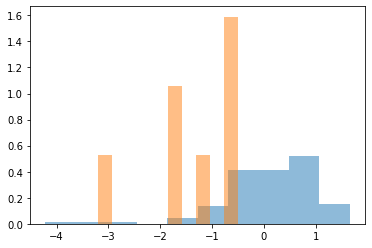

In [101]:
plt.hist(real_preds, density=True, alpha=0.5)
plt.hist(gen_preds, density=True, alpha=0.5)

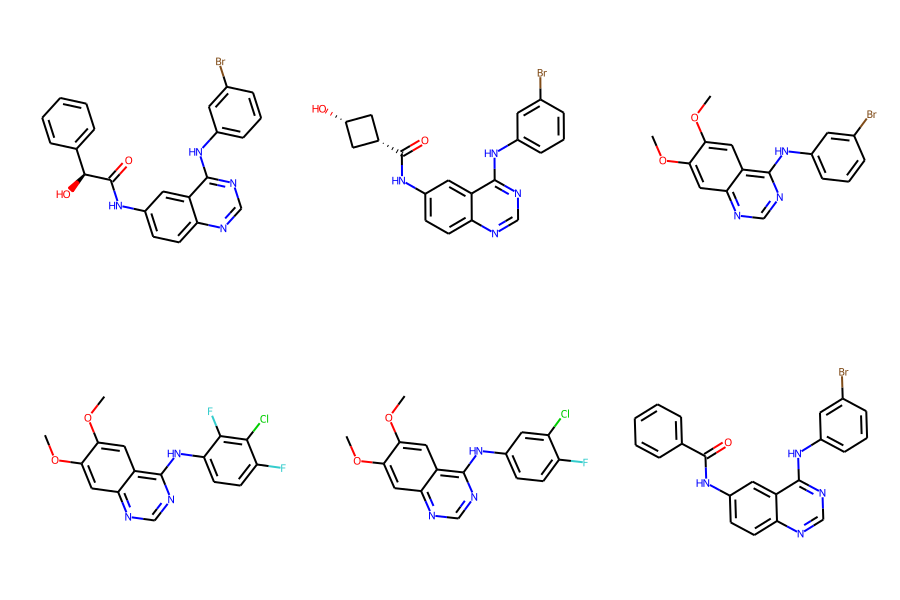

In [92]:
draw_mols(to_mols(smiles))